<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/09_transformer/09_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchtext==0.15.1

### Defining helper functions

In [9]:
import matplotlib.pyplot as plt

def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()



def plot_tras(words, model):
    # Tokenize the input words using a tokenizer function
    tokens = tokenizer(words)

    # Define the model's embedding dimension (d_model)
    d_model = 100

    # Convert the input words to a PyTorch tensor and move it to the specified device
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    x_ = model.emb(x) * math.sqrt(d_model)

    # Apply the model's positional encoder to the embeddings
    x = model.pos_encoder(x_)

    # Extract projection weights for query, key, and value from the model's state_dict
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:embed_dim].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

    # Calculate query (Q), key (K), and value (V) matrices
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate attention scores using dot-product attention
    scores = Q @ K.T

    # Set row and column labels for the attention matrix
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Dot-Product Attention")
    plt.show()

    # Apply softmax to the attention scores and create a heatmap
    att = nn.Softmax(dim=1)(scores)
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Scaled Dot-Product Attention")
    plt.show()

    # Calculate the attention head by multiplying softmax scores with values (V)
    head = nn.Softmax(dim=1)(scores) @ V

    # Visualize the embeddings and attention heads using t-SNE
    tsne(x_, tokens, title="Embeddings")
    tsne(head, tokens, title="Attention Heads")


def tsne(embeddings, tokens, title="Embeddings"):
    # Initialize t-SNE with 2 components and a fixed random state
    tsne = TSNE(n_components=2, random_state=0)

    # Fit t-SNE to the embeddings (converting from GPU if necessary)
    tsne_result = tsne.fit_transform(embeddings.squeeze(0).cpu().detach().numpy())

    # Create a scatter plot of the t-SNE results
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

    # Set a title for the plot
    plt.title(title)

    # Add labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        # Place the label text at the corresponding t-SNE coordinates
        plt.text(tsne_result[j, 0], tsne_result[j, 1], label)

    plt.show()

def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

## Toy dataset

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

## Zero padding

In [4]:
import torch

sequences = [torch.tensor([j for j in range(1,i)]) for i in range(2,10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

In [5]:
from torch.nn.utils.rnn import pad_sequence

padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


## Positional encodings

In [6]:
import torch.nn as nn

my_tokens='he painted the car red he painted the red car'

my_index=text_pipeline(my_tokens)
my_index

embedding_dim=3

vocab_size=len(vocab)
print(vocab_size)

embedding = nn.Embedding(vocab_size, embedding_dim)

27


In [7]:
# !pip uninstall numpy
# !pip install "numpy<2"

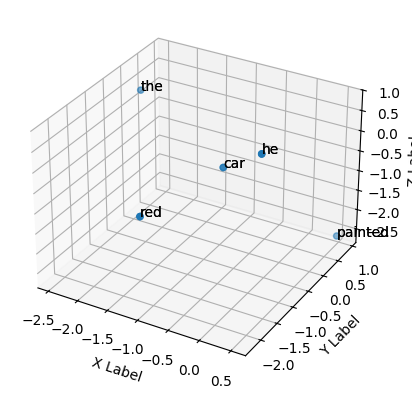

In [10]:
my_embdings = embedding(torch.tensor(my_index)).detach().numpy()
plot_embdings(my_embdings,tokenizer(my_tokens),vocab)

In [14]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

## Encoder layer

In [16]:
encoder_layer=nn.TransformerEncoderLayer(
            d_model=3,
            nhead=1,
            dim_feedforward=1,
            dropout=0,
        )

embed_dim=3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

## Query, key, and value

In [28]:
my_embdings_torch = torch.tensor(my_embdings)
Q = my_embdings_torch@q_proj_weight
K = my_embdings_torch@k_proj_weight
V = my_embdings_torch@v_proj_weight

In [29]:
import numpy as np

scores=Q@K.T/np.sqrt(embed_dim)
scores

tensor([[-0.1127,  0.2691, -0.0379, -0.0034, -0.0630, -0.1127,  0.2691, -0.0379,
         -0.0630, -0.0034],
        [ 0.0435,  0.3606, -1.0066, -0.2458, -0.4223,  0.0435,  0.3606, -1.0066,
         -0.4223, -0.2458],
        [-0.1464, -0.3583,  1.2407,  0.2517,  0.3297, -0.1464, -0.3583,  1.2407,
          0.3297,  0.2517],
        [-0.1567,  0.2685,  0.0587, -0.0031, -0.1078, -0.1567,  0.2685,  0.0587,
         -0.1078, -0.0031],
        [-0.4565,  0.9596, -0.1364, -0.0663, -0.4017, -0.4565,  0.9596, -0.1364,
         -0.4017, -0.0663],
        [-0.1127,  0.2691, -0.0379, -0.0034, -0.0630, -0.1127,  0.2691, -0.0379,
         -0.0630, -0.0034],
        [ 0.0435,  0.3606, -1.0066, -0.2458, -0.4223,  0.0435,  0.3606, -1.0066,
         -0.4223, -0.2458],
        [-0.1464, -0.3583,  1.2407,  0.2517,  0.3297, -0.1464, -0.3583,  1.2407,
          0.3297,  0.2517],
        [-0.4565,  0.9596, -0.1364, -0.0663, -0.4017, -0.4565,  0.9596, -0.1364,
         -0.4017, -0.0663],
        [-0.1567,  

In [30]:
head=nn.Softmax(dim=1)(scores)@V
head

tensor([[-0.0019, -0.3844, -0.1744],
        [ 0.3224, -0.1657, -0.0537],
        [-0.7402, -0.8248, -0.4393],
        [-0.0211, -0.4030, -0.1995],
        [ 0.6162, -0.1542, -0.2282],
        [-0.0019, -0.3844, -0.1744],
        [ 0.3224, -0.1657, -0.0537],
        [-0.7402, -0.8248, -0.4393],
        [ 0.6162, -0.1542, -0.2282],
        [-0.0211, -0.4030, -0.1995]])

## Attention weights and linear transformation